# Unit Testing of Cell Modules

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotnine as p9

## Set-up Cell Modules

In [2]:
class CellLineNetwork(nn.Module):
    """Fully connected network to handle cell line information."""
    def __init__(self, input_dim: int, hidden_layers: dict[int, int], output_dim: int, dtype: torch.dtype = torch.float32, device: str = 'cpu'):
        """
        Initialization method.

        Parameters
        ----------
        input_dim : int
            Number of input neurons (number of cell lines).
        hidden_layers : Dict[int, int]
            Dictionary specifying the number of hidden layers and their sizes. Keys are layer indices (starting from 1) and values are the number of neurons.
        output_dim : int
            Number of output neurons (same as the shape of the bias in X_bias).
        dtype : torch.dtype, optional
            Datatype to store values in torch, by default torch.float32.
        device : str, optional
            Whether to use gpu ("cuda") or cpu ("cpu"), by default "cpu".
        """
        super().__init__()
        self.device = device
        self.dtype = dtype

        layers = []
        prev_dim = input_dim

        # Add hidden layers if any
        if hidden_layers:
            for i in range(1, len(hidden_layers) + 1):
                layers.append(nn.Linear(prev_dim, hidden_layers[i]).to(device, dtype))
                layers.append(nn.ReLU())
                prev_dim = hidden_layers[i]

        # Add output layer
        layers.append(nn.Linear(prev_dim, output_dim).to(device, dtype))
        self.network = nn.Sequential(*layers)

    def forward(self, X_cell: torch.Tensor):
        """
        Forward pass to compute the bias term.

        Parameters
        ----------
        X_cell : torch.Tensor
            The cell line input tensor. Shape is (samples x cell lines).

        Returns
        -------
        X_bias : torch.Tensor
            The computed bias term. Shape is (samples x output_dim).
        """
        X_bias = self.network(X_cell)
        return X_bias
    
    def L2_reg(self, lambda_L2: float = 0):
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.sum(param ** 2)
        return lambda_L2 * reg_loss
    

class XssCellLineNetwork(nn.Module):
    """Fully connected network to handle cell line information."""
    def __init__(self, input_dim: int, hidden_layers: dict[int, int], output_dim: int, dtype: torch.dtype = torch.float32, device: str = 'cpu'):
        """
        Initialization method.

        Parameters
        ----------
        input_dim : int
            Number of input neurons (number of cell lines).
        hidden_layers : Dict[int, int]
            Dictionary specifying the number of hidden layers and their sizes. Keys are layer indices (starting from 1) and values are the number of neurons.
        output_dim : int
            Number of output neurons (same as the shape of the bias in X_bias).
        dtype : torch.dtype, optional
            Datatype to store values in torch, by default torch.float32.
        device : str, optional
            Whether to use gpu ("cuda") or cpu ("cpu"), by default "cpu".
        """
        super().__init__()
        self.device = device
        self.dtype = dtype

        layers = []
        prev_dim = input_dim

        # Add hidden layers if any
        if hidden_layers:
            for i in range(1, len(hidden_layers) + 1):
                layers.append(nn.Linear(prev_dim, hidden_layers[i]).to(device, dtype))
                layers.append(nn.ReLU())
                prev_dim = hidden_layers[i]

        # Add output layer
        layers.append(nn.Linear(prev_dim, output_dim).to(device, dtype))
        self.network = nn.Sequential(*layers)

    def forward(self, X_cell: torch.Tensor):
        """
        Forward pass to compute the bias term.

        Parameters
        ----------
        X_cell : torch.Tensor
            The cell line input tensor. Shape is (samples x cell lines).

        Returns
        -------
        X_bias : torch.Tensor
            The computed bias term. Shape is (samples x output_dim).
        """
        X_bias = self.network(X_cell)
        return X_bias
    
    def L2_reg(self, lambda_L2: float = 0):
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.sum(torch.square(param))
        return lambda_L2 * reg_loss

## Create test cases

1. Cell basal activity

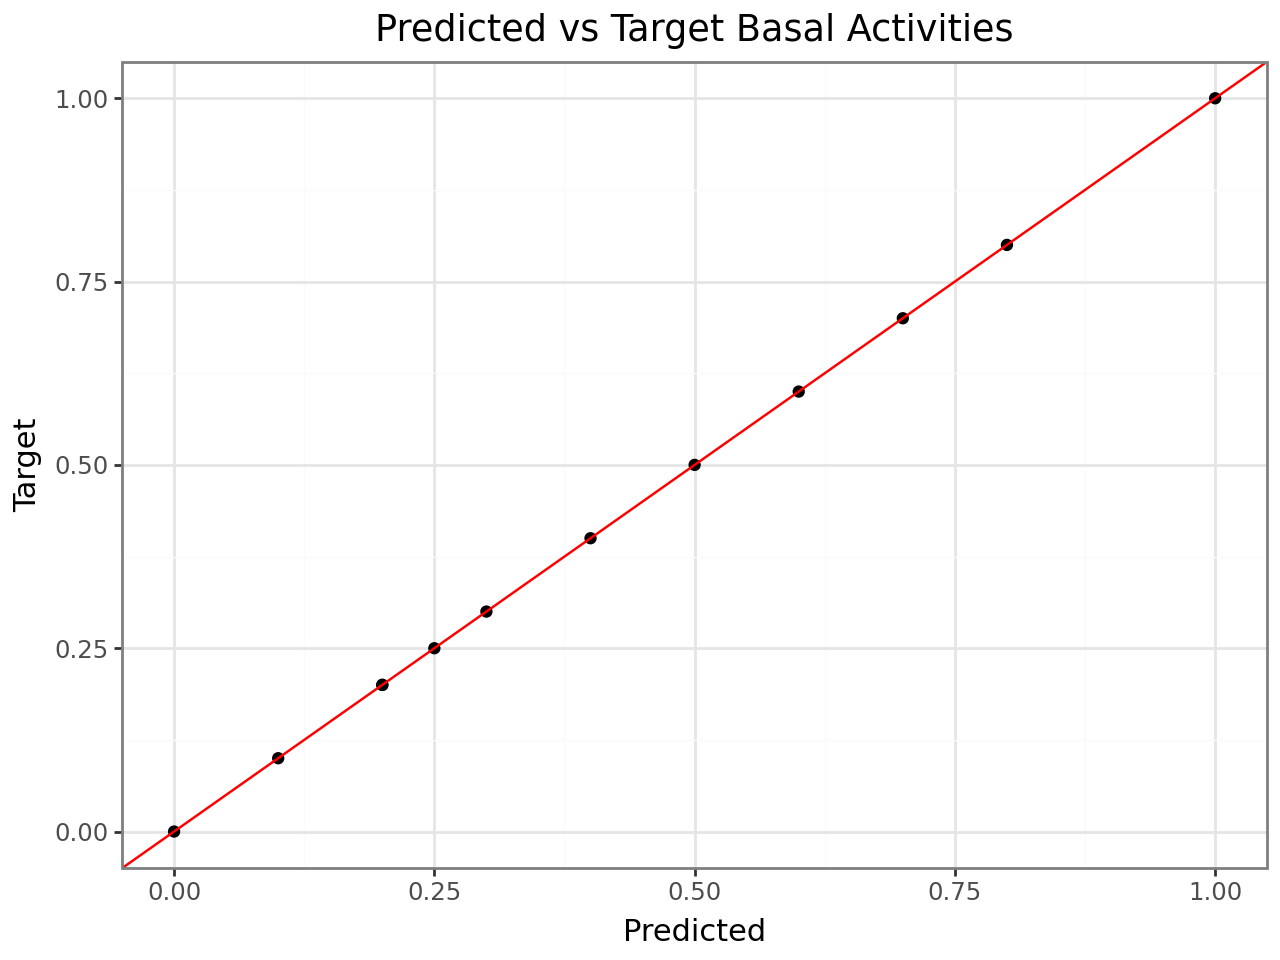

In [ ]:
input_dim = 3       # Three cell lines
output_dim = 4      # Four nodes in the signaling network
hidden_layers = {}
model = XssCellLineNetwork(input_dim, hidden_layers, output_dim)

# One-hot encodings for 3 cell lines
X_cell = torch.eye(input_dim)

# Target basal activity per cell line (3 cell lines × 4 nodes)
Y_target = torch.tensor([
    [1.0, 0.5, 0.0, 0.2],   # Cell line 1
    [0.2, 0.1, 0.8, 0.4],   # Cell line 2
    [0.25, 0.3, 0.6, 0.7],   # Cell line 3
])

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Train the model to learn the mapping
for _ in range(500):
    pred = model(X_cell)
    loss = loss_fn(pred, Y_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Final prediction
with torch.no_grad():
    pred = model(X_cell)
    
    df = pd.DataFrame({
        'Predicted': pred.numpy().flatten(),
        'Target': Y_target.numpy().flatten()
    })
    
    plot = (p9.ggplot(df, p9.aes(x='Predicted', y='Target')) +
            p9.geom_point() +
            p9.geom_abline(slope=1, intercept=0, color='red') +
            p9.theme_bw() +
            p9.ggtitle('Predicted vs Target Basal Activities') +
            p9.xlab('Predicted') +
            p9.ylab('Target'))
    plot.show()

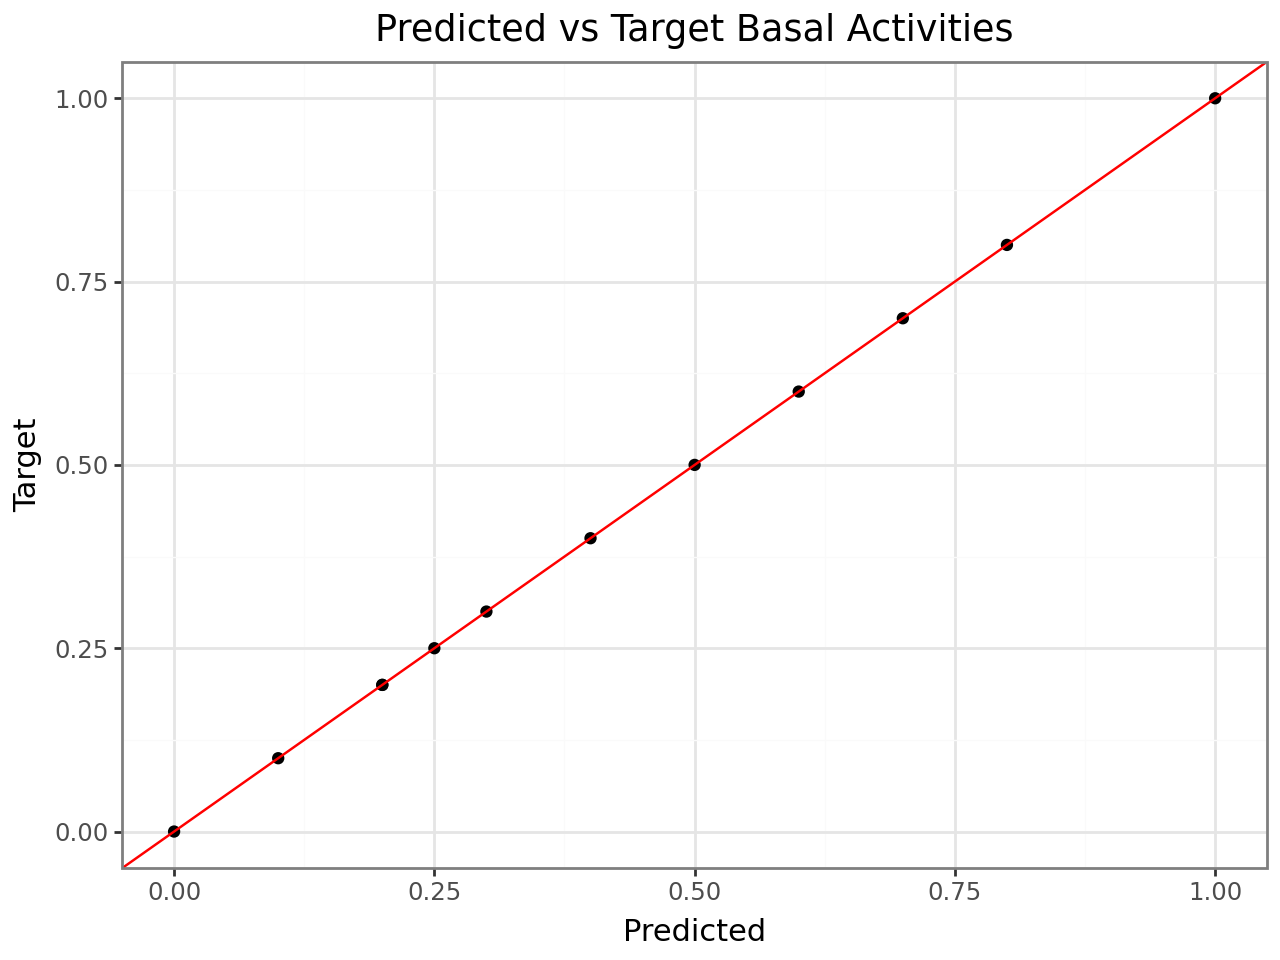

In [ ]:
input_dim = 3       # Three cell lines
output_dim = 4      # Four nodes in the signaling network
hidden_layers = {}
model = CellLineNetwork(input_dim, hidden_layers, output_dim)

# One-hot encodings for 3 cell lines
X_cell = torch.eye(input_dim)

# Target basal activity per cell line (3 cell lines × 4 nodes)
Y_target = torch.tensor([
    [1.0, 0.5, 0.0, 0.2],   # Cell line 1
    [0.2, 0.1, 0.8, 0.4],   # Cell line 2
    [0.25, 0.3, 0.6, 0.7],   # Cell line 3
])

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Train the model to learn the mapping
for _ in range(500):
    pred = model(X_cell)
    loss = loss_fn(pred, Y_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Final prediction
with torch.no_grad():
    pred = model(X_cell)
    
    df = pd.DataFrame({
        'Predicted': pred.numpy().flatten(),
        'Target': Y_target.numpy().flatten()
    })
    
    plot = (p9.ggplot(df, p9.aes(x='Predicted', y='Target')) +
            p9.geom_point() +
            p9.geom_abline(slope=1, intercept=0, color='red') +
            p9.theme_bw() +
            p9.ggtitle('Predicted vs Target Basal Activities') +
            p9.xlab('Predicted') +
            p9.ylab('Target'))
    plot.show()